# Experiments 4:
### generating byte frequency distributions derived from file body blocks to train and evaluate our models - FFNN, CNN, GRU, LSTM

In [1]:
import os

import numpy as np
import pandas as pd

from toolkit.utils import get_file_types, get_2nd_block_bytes, convert_cat2num, byte_frequency_histogram
from toolkit.models import Ffnn, Ffnn2, Cnn, Cnn2, Lstm, Gru
from toolkit.metrics import evaluate_performance, plot_confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

## 1. Data Preparation

In [2]:
dir_path = 'govdocs1/'
files_data = get_file_types(dir_path)
df = pd.DataFrame(files_data)

In [3]:
df['size KB'] = df['file'].apply(
    lambda x: float(os.path.getsize(
        os.path.join(os.getcwd(), f"govdocs1/{x}")
    ) / 1024) if os.path.isfile(
        os.path.join(os.getcwd(), f"govdocs1/{x}")
    ) else None
)

print(f"The average file size is: {df['size KB'].mean()}")

The average file size is: 519.8767892054933


In [4]:
CLASS_NAMES = [
    "doc",
    "pdf",
    "ps",
    "xls",
    "ppt",
    "swf",
    "gif",
    "jpg",
    "png",
    "html",
    "txt",
    "xml"
]

In [5]:
# we sample files whose size is larger than 16 kb
# this is to ensure we have 2 body blocks at least
df = df[df['type'].isin(CLASS_NAMES)]
df = df[df['size KB'] > 16]
df['type'].value_counts()

type
pdf     168373
html    110537
doc      52927
xls      45050
txt      42195
jpg      41034
ppt      39412
xml      13837
ps       12275
gif       8412
swf       2694
png       1356
Name: count, dtype: int64

In [6]:
# sample 12 file types
df = df.groupby('type').apply(
    lambda x: x if x.name == "png" else x.sample(n=min(len(x), 2000), random_state=42)
).reset_index(drop=True)

df["type"].value_counts()

C:\Users\User\AppData\Local\Temp\ipykernel_19220\3309657051.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('type').apply(


type
doc     2000
gif     2000
html    2000
jpg     2000
pdf     2000
ppt     2000
ps      2000
swf     2000
txt     2000
xls     2000
xml     2000
png     1356
Name: count, dtype: int64

In [7]:
base_dir = os.path.join(os.getcwd(), "govdocs1")
df["body_block_bytes"] = df["file"].apply(lambda file: get_2nd_block_bytes(os.path.join(base_dir, file)))
df["byte_integers"] = df["body_block_bytes"].apply(lambda byte_sequences: np.array([byte for byte in byte_sequences]))

In [8]:
byte_lengths = df["byte_integers"].apply(len)
all_same_length = byte_lengths.nunique() == 1

print("byte lengths of each sequence:\n", byte_lengths)
print("all byte sequences of the same length:", all_same_length)

byte lengths of each sequence:
 0        4096
1        4096
2        4096
3        4096
4        4096
         ... 
23351    4096
23352    4096
23353    4096
23354    4096
23355    4096
Name: byte_integers, Length: 23356, dtype: int64
all byte sequences of the same length: True


In [9]:
df.head(5)

,file,type,size KB,body_block_bytes,byte_integers
0,459548.doc,doc,390.5,b'n where (which folder) this is before you le...,"[110, 32, 119, 104, 101, 114, 101, 32, 40, 119..."
1,609183.doc,doc,86.5,b' MERGEFORMAT \x14\x08\x01\x15\r2008 BNL Scie...,"[32, 77, 69, 82, 71, 69, 70, 79, 82, 77, 65, 8..."
2,284373.doc,doc,61.0,"b""649\x96656. \rAhluwalia IB, Tessaro I, Grumm...","[54, 52, 57, 150, 54, 53, 54, 46, 32, 13, 65, ..."
3,010461.doc,doc,129.5,b' more thorough understanding of auction outc...,"[32, 109, 111, 114, 101, 32, 116, 104, 111, 11..."
4,430917.doc,doc,58.0,"b' Now, it became clear that most of the decis...","[32, 78, 111, 119, 44, 32, 105, 116, 32, 98, 1..."


In [10]:
df["byte_bfh"] = df["byte_integers"].apply(lambda byte_integers: byte_frequency_histogram(byte_integers))

In [11]:
df["byte_bfh"].apply(len)

0        256
1        256
2        256
3        256
4        256
        ... 
23351    256
23352    256
23353    256
23354    256
23355    256
Name: byte_bfh, Length: 23356, dtype: int64

In [12]:
df.sample(n=5)

,file,type,size KB,body_block_bytes,byte_integers,byte_bfh
8111,254817.pdf,pdf,24.717773,b'\xcag\xc9\x8fb\x88q!Z\xf9)\xf8m\xd0\xd7EYp7u...,"[202, 103, 201, 143, 98, 136, 113, 33, 90, 249...","[16, 14, 19, 12, 8, 8, 14, 15, 16, 13, 9, 17, ..."
9790,552495.pdf,pdf,4201.428711,b'\xae\xcb\xfdag\xc9\x17\xe7\xe9\xb5m\xfac\xff...,"[174, 203, 253, 97, 103, 201, 23, 231, 233, 18...","[50, 33, 22, 15, 15, 23, 18, 24, 26, 17, 25, 1..."
17079,655055.swf,swf,41.819336,b'\xea\x16\n\x84kDP\x17\xa9V8-\xacZ`^\xa5\xb8\...,"[234, 22, 10, 132, 107, 68, 80, 23, 169, 86, 5...","[317, 60, 17, 8, 35, 13, 29, 16, 27, 16, 13, 3..."
21740,708641.xml,xml,1051.511719,"b'nt Detail"">http://www.gpo.gov/fdsys/granule/...","[110, 116, 32, 68, 101, 116, 97, 105, 108, 34,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 94, 0, 0, 0, 0,..."
7834,735765.jpg,jpg,23.819336,b'u\x9b`\xaf\xfb\xb9\x93;$Q\xc8\xff\x00\x11^7\...,"[117, 155, 96, 175, 251, 185, 147, 59, 36, 81,...","[104, 26, 42, 41, 28, 43, 18, 32, 17, 8, 19, 9..."


In [13]:
df["class"] = df["type"].apply(lambda file_type: convert_cat2num(file_type))

In [14]:
df.sample(n=5)

,file,type,size KB,body_block_bytes,byte_integers,byte_bfh,class
8357,528205.pdf,pdf,309.973633,b'\xbfD\\~}L\x9d\x1bwa\xa1a\x18\xecZL\xdbT\xbd...,"[191, 68, 92, 126, 125, 76, 157, 27, 119, 97, ...","[9, 16, 16, 22, 20, 16, 16, 19, 14, 20, 37, 15...",2
18077,014534.txt,txt,1527.963867,b'pha virginica L. ...,"[112, 104, 97, 32, 118, 105, 114, 103, 105, 11...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 19, 0, 0, 19, 0...",11
12481,093144.ppt,ppt,2654.000000,b']\xc6\x1cOn7:\xa8\xe4`\xe0\x92~\xbcc\xb5YZ\x...,"[93, 198, 28, 79, 110, 55, 58, 168, 228, 96, 2...","[36, 19, 8, 28, 17, 19, 22, 22, 10, 13, 19, 14...",5
5288,649742.html,html,20.818359,b'0;&#160;&#160;&#160;&#160;</span>The Sixth C...,"[48, 59, 38, 35, 49, 54, 48, 59, 38, 35, 49, 5...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 43, 0, 0, 43, 0...",10
5826,213078.html,html,17.566406,"b'ear"" ><br>Mostly<br>Clear<br>Lo <font color=...","[101, 97, 114, 34, 32, 62, 60, 98, 114, 62, 77...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 0, 0, 0, 0,...",10


In [15]:
X = np.array([x for x in df["byte_bfh"]])
y = np.array([y for y in df["class"]])

In [16]:
print("X shape: ", X.shape)
print("y shape: ", y.shape)

X shape:  (23356, 256)
y shape:  (23356,)


In [17]:
# 70% train
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
# 15% validation and 15% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [18]:
print("X training shape: ", X_train.shape)
print("X validation shape: ", X_val.shape)
print("X testing shape: ", X_test.shape, "\n")
print("y training shape: ", y_train.shape)
print("y validation shape: ", y_val.shape)
print("y testing shape: ", y_test.shape)

X training shape:  (16349, 256)
X validation shape:  (3503, 256)
X testing shape:  (3504, 256) 

y training shape:  (16349,)
y validation shape:  (3503,)
y testing shape:  (3504,)


## 2. Models Training and Evaluation

### Feed Forward Neural Network

#### a. Base FFNN

In [19]:
ffnn = Ffnn(timesteps=256, features=1)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256, 256)       │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256, 128)       │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 13)             │       425,997 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 459,405 (1.75 MB)

 Trainable params: 459,405 (1.75 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
ffnn.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=4,
    batch_size=32
)

Epoch 1/4
511/511 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.5870 - loss: 1.7111 - val_accuracy: 0.7696 - val_loss: 0.7094
Epoch 2/4
511/511 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.7870 - loss: 0.6578 - val_accuracy: 0.8067 - val_loss: 0.6672
Epoch 3/4
511/511 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.8114 - loss: 0.5887 - val_accuracy: 0.8050 - val_loss: 0.6291
Epoch 4/4
511/511 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.8204 - loss: 0.5357 - val_accuracy: 0.7799 - val_loss: 0.6367


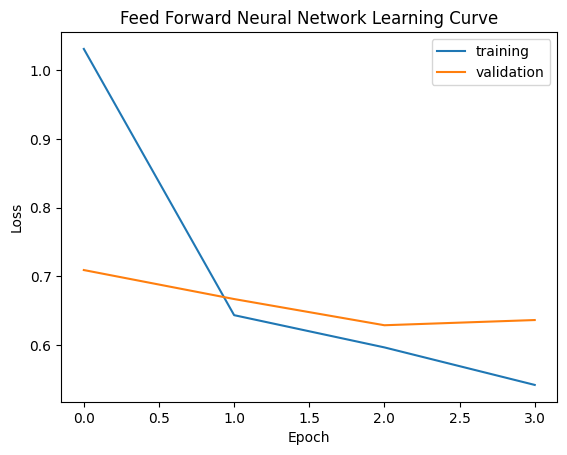

In [21]:
ffnn.plot_learning_curves()

In [22]:
ffnn_pred = ffnn.predict(X_test)

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [23]:
metrics = evaluate_performance(y_test, ffnn_pred)
accuracy, precision, recall, f1 = metrics["accuracy"], metrics["precision"], metrics["recall"], metrics["f1_score"]
print(f"""{ffnn.name} performance evaluation:\n\naccuracy\t{accuracy}.\n\
precision\t{precision}.\nrecall\t\t{recall}.\nf1-score\t{f1}.""")

Feed Forward Neural Network performance evaluation:

accuracy	0.7751141552511416.
precision	0.7929474873837826.
recall		0.7729189132917034.
f1-score	0.773417029689302.


In [24]:
ffnn_report = classification_report(y_test, ffnn_pred, target_names=CLASS_NAMES)
print(ffnn_report)

              precision    recall  f1-score   support

         doc       0.95      0.98      0.97       278
         pdf       0.97      0.80      0.88       306
          ps       0.98      0.96      0.97       305
         xls       0.98      0.94      0.96       301
         ppt       0.42      0.46      0.44       309
         swf       0.61      0.48      0.54       306
         gif       0.87      0.92      0.89       294
         jpg       0.75      0.81      0.78       310
         png       0.46      0.58      0.51       203
        html       0.60      0.96      0.74       287
         txt       0.96      0.72      0.82       301
         xml       0.96      0.66      0.78       304

    accuracy                           0.78      3504
   macro avg       0.79      0.77      0.77      3504
weighted avg       0.80      0.78      0.78      3504



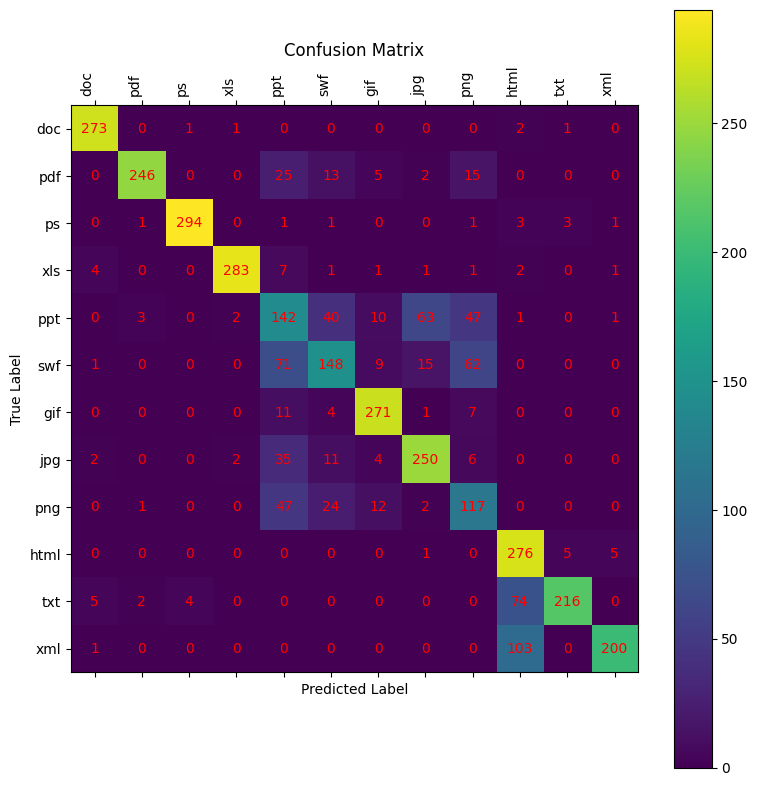

In [25]:
ffnn_cm = confusion_matrix(y_test, ffnn_pred)
plot_confusion_matrix(ffnn_cm, CLASS_NAMES)

#### b. Fine-tuned FFNN

In [26]:
ffnn2 = Ffnn2(timesteps=256, features=1)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 256, 352)       │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256, 32)        │        11,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 13)             │       106,509 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,509 (462.93 KB)

 Trainable params: 118,509 (462.93 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
ffnn2.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=4,
    batch_size=32
)

Epoch 1/4
511/511 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.6040 - loss: 1.2591 - val_accuracy: 0.7625 - val_loss: 0.7346
Epoch 2/4
511/511 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.8006 - loss: 0.6320 - val_accuracy: 0.8022 - val_loss: 0.6328
Epoch 3/4
511/511 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8150 - loss: 0.5669 - val_accuracy: 0.7908 - val_loss: 0.6258
Epoch 4/4
511/511 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.8137 - loss: 0.5469 - val_accuracy: 0.8059 - val_loss: 0.5728


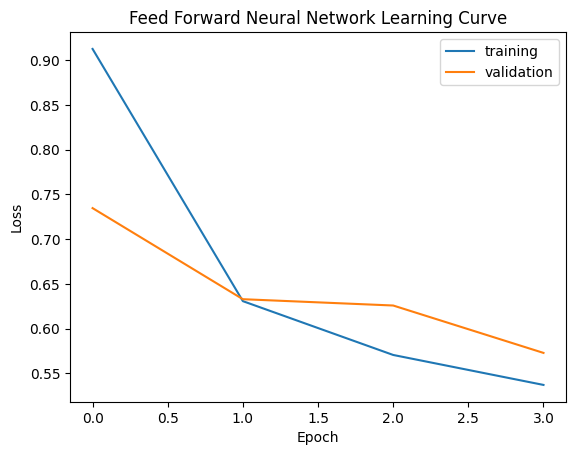

In [28]:
ffnn2.plot_learning_curves()

In [29]:
ffnn2_pred = ffnn2.predict(X_test)

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [30]:
metrics = evaluate_performance(y_test, ffnn2_pred)
accuracy, precision, recall, f1 = metrics["accuracy"], metrics["precision"], metrics["recall"], metrics["f1_score"]
print(f"""{ffnn2.name} performance evaluation:\n\naccuracy\t{accuracy}.\n\
precision\t{precision}.\nrecall\t\t{recall}.\nf1-score\t{f1}.""")

Feed Forward Neural Network performance evaluation:

accuracy	0.8090753424657534.
precision	0.8143529681176749.
recall		0.8036643171800041.
f1-score	0.8029845414465298.


In [31]:
ffnn2_report = classification_report(y_test, ffnn2_pred, target_names=CLASS_NAMES)
print(ffnn2_report)

              precision    recall  f1-score   support

         doc       0.99      0.98      0.98       278
         pdf       0.97      0.80      0.88       306
          ps       1.00      0.94      0.97       305
         xls       0.99      0.93      0.96       301
         ppt       0.41      0.48      0.44       309
         swf       0.68      0.41      0.51       306
         gif       0.84      0.92      0.88       294
         jpg       0.67      0.90      0.76       310
         png       0.51      0.53      0.52       203
        html       0.93      0.84      0.88       287
         txt       0.89      0.97      0.93       301
         xml       0.89      0.96      0.92       304

    accuracy                           0.81      3504
   macro avg       0.81      0.80      0.80      3504
weighted avg       0.82      0.81      0.81      3504



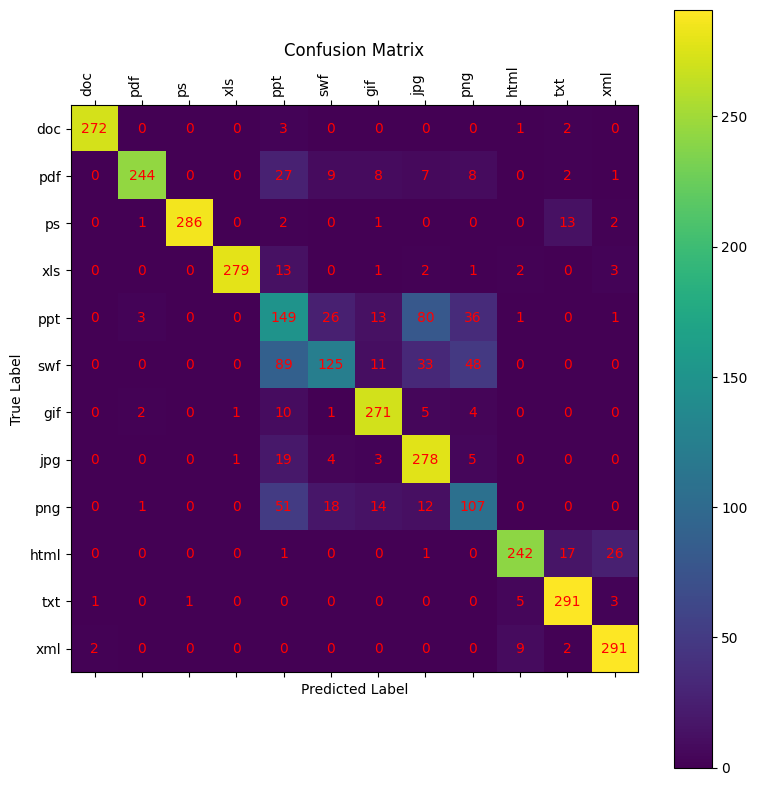

In [32]:
ffnn2_cm = confusion_matrix(y_test, ffnn2_pred)
plot_confusion_matrix(ffnn2_cm, CLASS_NAMES)

### Convolutional Neural Network

#### a. Base CNN

In [33]:
cnn = Cnn(timesteps=256, features=1)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 254, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 127, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 125, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 62, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 7936)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 13)             │       103,181 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,141 (500.55 KB)

 Trainable params: 128,141 (500.55 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
cnn.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=4,
    batch_size=32
)

Epoch 1/4
511/511 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5813 - loss: 2.3832 - val_accuracy: 0.7556 - val_loss: 0.7505
Epoch 2/4
511/511 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7887 - loss: 0.6339 - val_accuracy: 0.7936 - val_loss: 0.6317
Epoch 3/4
511/511 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8221 - loss: 0.5385 - val_accuracy: 0.7993 - val_loss: 0.6293
Epoch 4/4
511/511 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8341 - loss: 0.4819 - val_accuracy: 0.7822 - val_loss: 0.6615


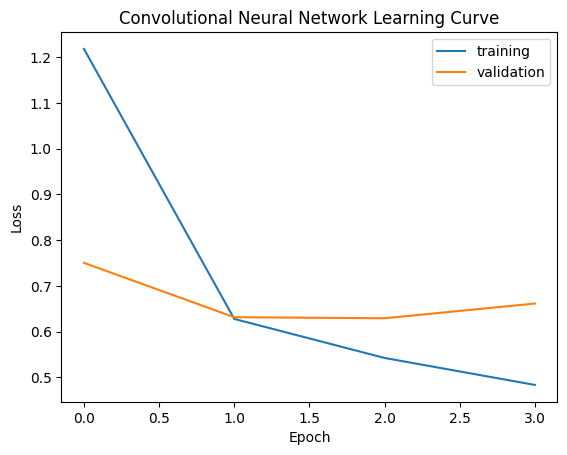

In [35]:
cnn.plot_learning_curves()

In [36]:
cnn_pred = cnn.predict(X_test)

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [37]:
metrics = evaluate_performance(y_test, cnn_pred)
accuracy, precision, recall, f1 = metrics["accuracy"], metrics["precision"], metrics["recall"], metrics["f1_score"]
print(f"""{cnn.name} performance evaluation:\n\naccuracy\t{accuracy}.\n\
precision\t{precision}.\nrecall\t\t{recall}.\nf1-score\t{f1}.""")

Convolutional Neural Network performance evaluation:

accuracy	0.781392694063927.
precision	0.8026784119161561.
recall		0.7711695204726531.
f1-score	0.7627243825878488.


In [38]:
cnn_report = classification_report(y_test, cnn_pred, target_names=CLASS_NAMES)
print(cnn_report)

              precision    recall  f1-score   support

         doc       0.95      0.99      0.97       278
         pdf       0.94      0.80      0.87       306
          ps       0.95      0.97      0.96       305
         xls       0.97      0.91      0.94       301
         ppt       0.66      0.23      0.34       309
         swf       0.45      0.83      0.58       306
         gif       0.69      0.95      0.80       294
         jpg       0.75      0.75      0.75       310
         png       0.68      0.30      0.41       203
        html       0.74      0.90      0.81       287
         txt       0.92      0.69      0.79       301
         xml       0.92      0.95      0.93       304

    accuracy                           0.78      3504
   macro avg       0.80      0.77      0.76      3504
weighted avg       0.81      0.78      0.77      3504



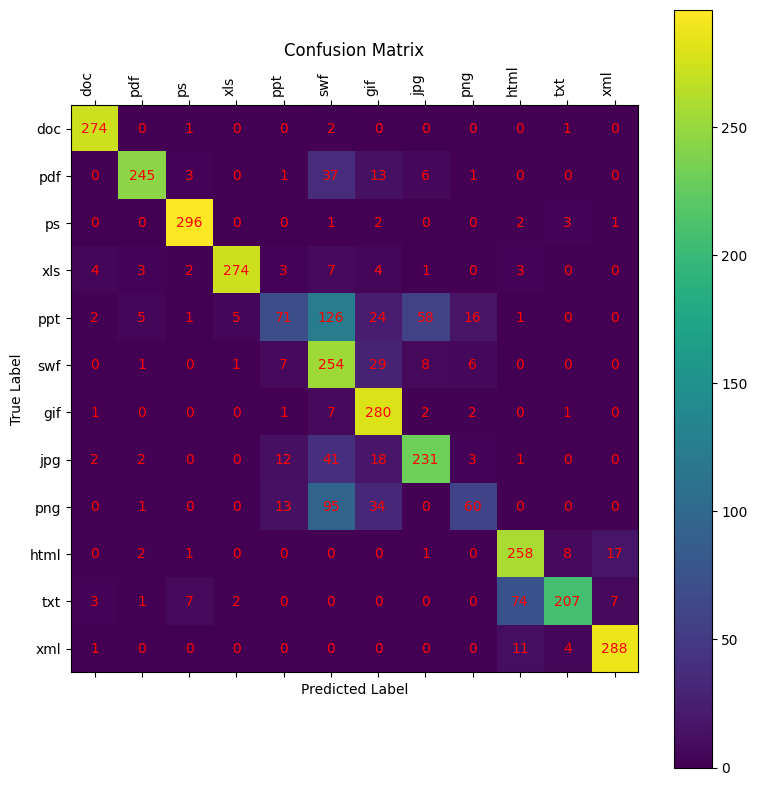

In [39]:
cnn_cm = confusion_matrix(y_test, cnn_pred)
plot_confusion_matrix(cnn_cm, CLASS_NAMES)

#### b. Fine-tuned CNN

In [40]:
cnn2 =  Cnn2(timesteps=256, features=1)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 254, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 127, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 125, 192)       │        37,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 62, 192)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 11904)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 11904)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │     3,047,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 13)             │         3,341 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,088,333 (11.78 MB)

 Trainable params: 3,088,333 (11.78 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
cnn2.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=6,
    batch_size=32
)

Epoch 1/6
511/511 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - accuracy: 0.5625 - loss: 2.7682 - val_accuracy: 0.7770 - val_loss: 0.7110
Epoch 2/6
511/511 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - accuracy: 0.7707 - loss: 0.6695 - val_accuracy: 0.7942 - val_loss: 0.6164
Epoch 3/6
511/511 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - accuracy: 0.8026 - loss: 0.5656 - val_accuracy: 0.7962 - val_loss: 0.6269
Epoch 4/6
511/511 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.8308 - loss: 0.4909 - val_accuracy: 0.8321 - val_loss: 0.5244
Epoch 5/6
511/511 ━━━━━━━━━━━━━━━━━━━━ 22s 42ms/step - accuracy: 0.8476 - loss: 0.4347 - val_accuracy: 0.8350 - val_loss: 0.5190
Epoch 6/6
511/511 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.8616 - loss: 0.4044 - val_accuracy: 0.8427 - val_loss: 0.5541


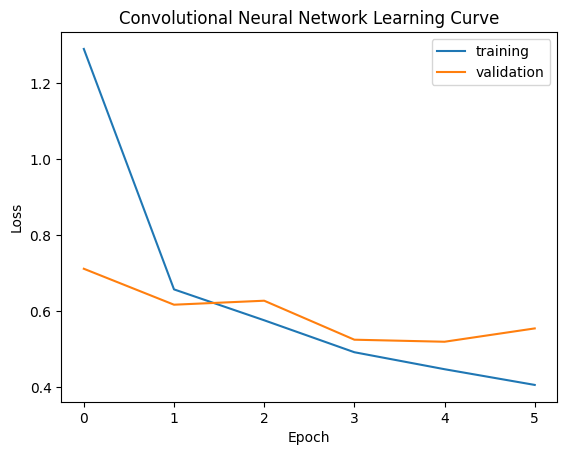

In [42]:
cnn2.plot_learning_curves()

In [43]:
cnn2_pred = cnn2.predict(X_test)

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [44]:
metrics = evaluate_performance(y_test, cnn2_pred)
accuracy, precision, recall, f1 = metrics["accuracy"], metrics["precision"], metrics["recall"], metrics["f1_score"]
print(f"""{cnn2.name} performance evaluation:\n\naccuracy\t{accuracy}.\n\
precision\t{precision}.\nrecall\t\t{recall}.\nf1-score\t{f1}.""")

Convolutional Neural Network performance evaluation:

accuracy	0.838755707762557.
precision	0.8362490950715881.
recall		0.8340592495375126.
f1-score	0.8304974353496118.


In [45]:
cnn2_report = classification_report(y_test, cnn2_pred, target_names=CLASS_NAMES)
print(cnn2_report)

              precision    recall  f1-score   support

         doc       0.97      0.97      0.97       278
         pdf       0.96      0.82      0.89       306
          ps       0.99      0.97      0.98       305
         xls       0.98      0.96      0.97       301
         ppt       0.67      0.43      0.52       309
         swf       0.68      0.74      0.71       306
         gif       0.83      0.93      0.88       294
         jpg       0.69      0.88      0.77       310
         png       0.57      0.59      0.58       203
        html       0.85      0.90      0.87       287
         txt       0.87      0.98      0.92       301
         xml       0.97      0.85      0.90       304

    accuracy                           0.84      3504
   macro avg       0.84      0.83      0.83      3504
weighted avg       0.84      0.84      0.84      3504



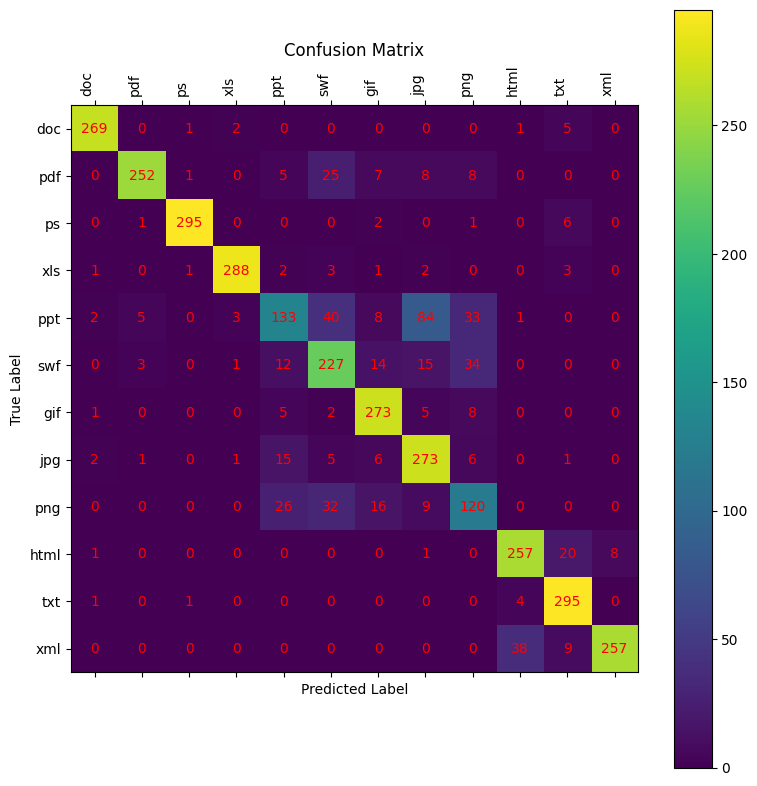

In [46]:
cnn2_cm = confusion_matrix(y_test, cnn2_pred)
plot_confusion_matrix(cnn2_cm, CLASS_NAMES)

### Gated Reccurent Unit

In [47]:
gru = Gru(timesteps=256, features=1)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 136)            │        28,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 13)             │         1,781 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,749 (120.11 KB)

 Trainable params: 30,749 (120.11 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
gru.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)

Epoch 1/10
511/511 ━━━━━━━━━━━━━━━━━━━━ 57s 106ms/step - accuracy: 0.3450 - loss: 1.7370 - val_accuracy: 0.5016 - val_loss: 1.2235
Epoch 2/10
511/511 ━━━━━━━━━━━━━━━━━━━━ 53s 104ms/step - accuracy: 0.5332 - loss: 1.1840 - val_accuracy: 0.6158 - val_loss: 1.0351
Epoch 3/10
511/511 ━━━━━━━━━━━━━━━━━━━━ 67s 131ms/step - accuracy: 0.6201 - loss: 1.0082 - val_accuracy: 0.6726 - val_loss: 0.8957
Epoch 4/10
511/511 ━━━━━━━━━━━━━━━━━━━━ 56s 109ms/step - accuracy: 0.6751 - loss: 0.8696 - val_accuracy: 0.6814 - val_loss: 0.8381
Epoch 5/10
511/511 ━━━━━━━━━━━━━━━━━━━━ 57s 112ms/step - accuracy: 0.7074 - loss: 0.7968 - val_accuracy: 0.7351 - val_loss: 0.7421
Epoch 6/10
511/511 ━━━━━━━━━━━━━━━━━━━━ 67s 130ms/step - accuracy: 0.7402 - loss: 0.7289 - val_accuracy: 0.7454 - val_loss: 0.7420
Epoch 7/10
511/511 ━━━━━━━━━━━━━━━━━━━━ 55s 109ms/step - accuracy: 0.7529 - loss: 0.7044 - val_accuracy: 0.7508 - val_loss: 0.7004
Epoch 8/10
511/511 ━━━━━━━━━━━━━━━━━━━━ 60s 117ms/step - accuracy: 0.7642 - loss: 0

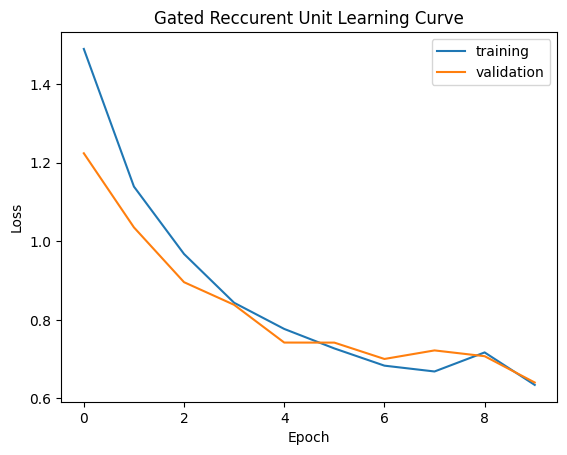

In [49]:
gru.plot_learning_curves()

In [50]:
gru_pred = gru.predict(X_test)

110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step


In [51]:
metrics = evaluate_performance(y_test, gru_pred)
accuracy, precision, recall, f1 = metrics["accuracy"], metrics["precision"], metrics["recall"], metrics["f1_score"]
print(f"""{gru.name} performance evaluation:\n\naccuracy\t{accuracy}.\n\
precision\t{precision}.\nrecall\t\t{recall}.\nf1-score\t{f1}.""")

Gated Reccurent Unit performance evaluation:

accuracy	0.7699771689497716.
precision	0.7707218791858405.
recall		0.7648734586800229.
f1-score	0.7616587516462746.


In [52]:
gru_report = classification_report(y_test, gru_pred, target_names=CLASS_NAMES)
print(gru_report)

              precision    recall  f1-score   support

         doc       0.87      0.96      0.91       278
         pdf       0.93      0.74      0.83       306
          ps       0.94      0.94      0.94       305
         xls       0.93      0.89      0.91       301
         ppt       0.47      0.37      0.41       309
         swf       0.69      0.67      0.68       306
         gif       0.90      0.98      0.94       294
         jpg       0.61      0.83      0.71       310
         png       0.52      0.48      0.50       203
        html       0.64      0.88      0.74       287
         txt       0.87      0.72      0.79       301
         xml       0.88      0.72      0.79       304

    accuracy                           0.77      3504
   macro avg       0.77      0.76      0.76      3504
weighted avg       0.78      0.77      0.77      3504



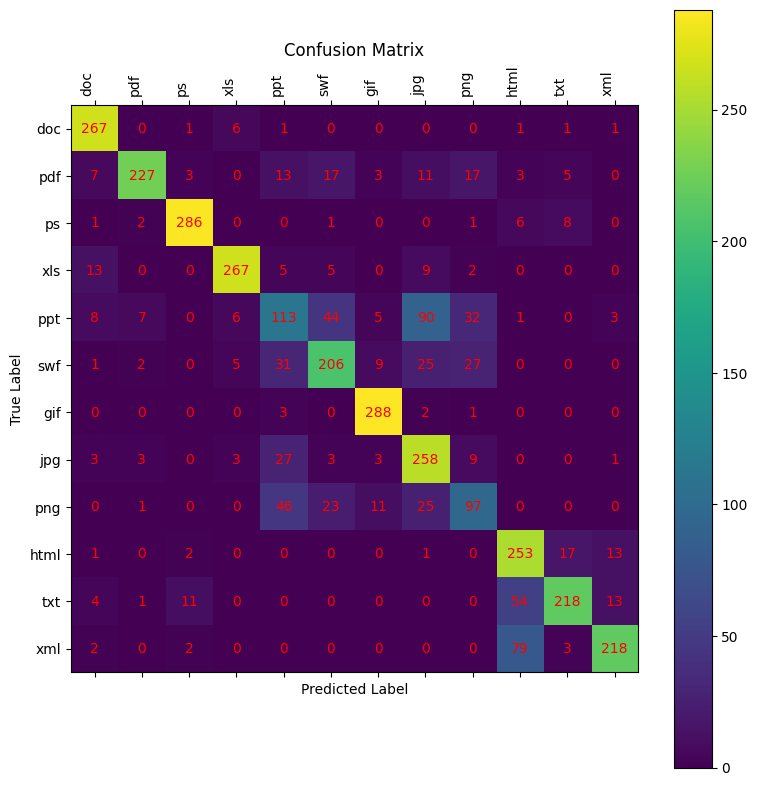

In [53]:
gru_cm = confusion_matrix(y_test, gru_pred)
plot_confusion_matrix(gru_cm, CLASS_NAMES)

### Long Short-Term Memory

In [54]:
lstm = Lstm(timesteps=256, features=1)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 136)            │        38,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 13)             │         1,781 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,861 (155.71 KB)

 Trainable params: 39,861 (155.71 KB)

 Non-trainable params: 0 (0.00 B)

In [55]:
lstm.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)

Epoch 1/10
511/511 ━━━━━━━━━━━━━━━━━━━━ 55s 102ms/step - accuracy: 0.3459 - loss: 1.7231 - val_accuracy: 0.5481 - val_loss: 1.2495
Epoch 2/10
511/511 ━━━━━━━━━━━━━━━━━━━━ 54s 105ms/step - accuracy: 0.5609 - loss: 1.1945 - val_accuracy: 0.6203 - val_loss: 1.0592
Epoch 3/10
511/511 ━━━━━━━━━━━━━━━━━━━━ 45s 89ms/step - accuracy: 0.6519 - loss: 0.9868 - val_accuracy: 0.6697 - val_loss: 0.9335
Epoch 4/10
511/511 ━━━━━━━━━━━━━━━━━━━━ 50s 97ms/step - accuracy: 0.6982 - loss: 0.8530 - val_accuracy: 0.7077 - val_loss: 0.8338
Epoch 5/10
511/511 ━━━━━━━━━━━━━━━━━━━━ 52s 102ms/step - accuracy: 0.7142 - loss: 0.8042 - val_accuracy: 0.7462 - val_loss: 0.7552
Epoch 6/10
511/511 ━━━━━━━━━━━━━━━━━━━━ 46s 90ms/step - accuracy: 0.7290 - loss: 0.7617 - val_accuracy: 0.7345 - val_loss: 0.7518
Epoch 7/10
511/511 ━━━━━━━━━━━━━━━━━━━━ 40s 79ms/step - accuracy: 0.7496 - loss: 0.7029 - val_accuracy: 0.7436 - val_loss: 0.7129
Epoch 8/10
511/511 ━━━━━━━━━━━━━━━━━━━━ 56s 110ms/step - accuracy: 0.7571 - loss: 0.671

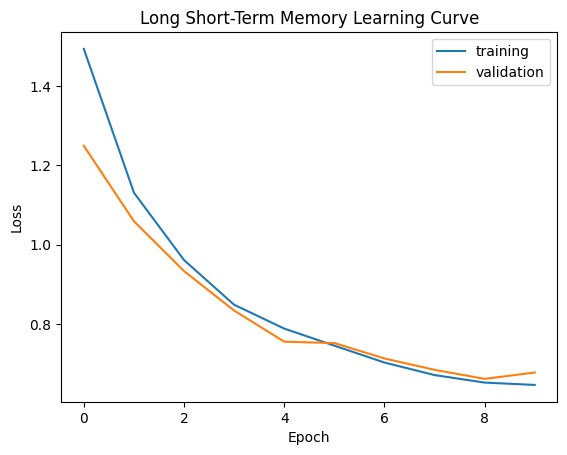

In [56]:
lstm.plot_learning_curves()

In [57]:
lstm_pred = lstm.predict(X_test)

110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step


In [58]:
metrics = evaluate_performance(y_test, lstm_pred)
accuracy, precision, recall, f1 = metrics["accuracy"], metrics["precision"], metrics["recall"], metrics["f1_score"]
print(f"""{lstm.name} performance evaluation:\n\naccuracy\t{accuracy}.\n\
precision\t{precision}.\nrecall\t\t{recall}.\nf1-score\t{f1}.""")

Long Short-Term Memory performance evaluation:

accuracy	0.7648401826484018.
precision	0.7596491797075121.
recall		0.759291283091912.
f1-score	0.7563438755892499.


In [59]:
lstm_report = classification_report(y_test, lstm_pred, target_names=CLASS_NAMES)
print(lstm_report)

              precision    recall  f1-score   support

         doc       0.87      0.88      0.88       278
         pdf       0.86      0.77      0.81       306
          ps       0.95      0.92      0.93       305
         xls       0.89      0.88      0.88       301
         ppt       0.45      0.33      0.38       309
         swf       0.66      0.59      0.62       306
         gif       0.91      0.95      0.93       294
         jpg       0.58      0.81      0.67       310
         png       0.43      0.48      0.45       203
        html       0.84      0.81      0.83       287
         txt       0.82      0.85      0.84       301
         xml       0.85      0.85      0.85       304

    accuracy                           0.76      3504
   macro avg       0.76      0.76      0.76      3504
weighted avg       0.77      0.76      0.76      3504



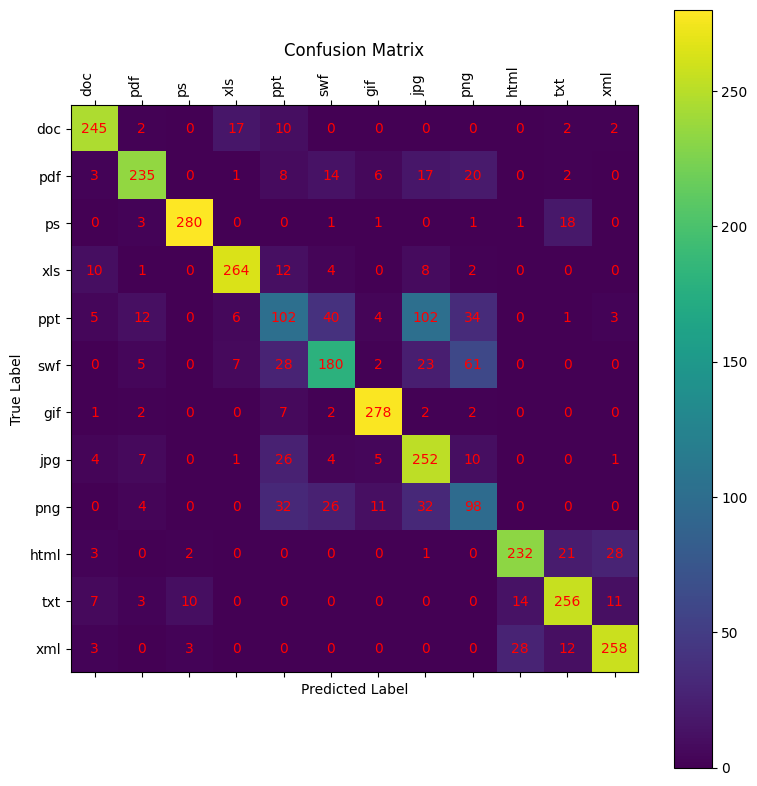

In [60]:
lstm_cm = confusion_matrix(y_test, lstm_pred)
plot_confusion_matrix(lstm_cm, CLASS_NAMES)